In [1]:
from loadingCGAN.swagan_trafic_input import Swagan_trafic_input
from learning_swagan_trafic_input import learning_swagan_trafic_input
from utils.config_swagan_trafic_input import *
import numpy as np
from load_data.load_data import load_data
from time import time
from loadingCGAN.utils_cgan import save_time
from loadingCGAN.utils_cgan import creating_dico_index
from evaluation.evaluation import evaluate
from loadingCGAN.mlp import Mlp
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
epochs = 2
number_of_gans = 2
switches = 2
examples = 10
smooth_zero = .1
smooth_one = .9
x_train_size = None
dropout = .2
leaky_relu = 0.1
noise = "normal"
activation = "tanh"
title = "swagan_trafic_input"
save_model = True
attack_mode = None
attack = None
noise_dim = 9
nrows = 10000
cv_size = .2
place = "home"
balanced_train_size = None
spectral_normalisation = False
shuffle = True
alpha = 1.
offset = 0.
batch_size = 128


In [3]:
########
# DATA #
########
x_train, _, y_train, _, x_balanced_train, _, x_test, y_test, colnames = load_data(place=place,
                                                                                  attack_mode=attack_mode,
                                                                                  attack=attack,
                                                                                  nrows=nrows,
                                                                                  cv_size=cv_size,
                                                                                  log_transform=True,
                                                                                  shuffle=shuffle,
                                                                                  return_colnames=True)
x_train_bad = np.array([x for x, y in zip(x_train, y_train) if int(y) == 1])
x_train = np.array([x for x, y in zip(x_train, y_train) if int(y) == 0])

x_test_bad = np.array([x for x, y in zip(x_test, y_test) if int(y) == 1])
x_test = np.array([x for x, y in zip(x_test, y_test) if int(y) == 0])



x_train, x_train_cv = train_test_split(x_train, test_size=cv_size)
x_train_bad, x_train_bad_cv = train_test_split(x_train_bad, test_size=cv_size)


if balanced_train_size is not None:
    x_balanced_train = x_balanced_train[:balanced_train_size]

data_dim = x_train.shape[1]
dico_index = creating_dico_index(colnames=colnames)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train data shape is (10000, 116)
Test data shape is (10000, 116)

  
 
 
  
 
 
Train data shape is (9416, 116)

  
 
 
  
 
 
x_train overview
        0         1         2    3    4    5    6    7    8    9    ...  106  \
0 -1.000000 -0.803047 -1.000000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0   
1 -1.000000 -0.293427 -0.236489 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0   
2 -1.000000 -0.527996 -0.354184 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0   
3 -0.869718 -0.317171 -0.251113 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0   
4 -1.000000 -1.000000 -1.000000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0   

   107  108  109  110  111  112  113  114  115  
0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
1 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
2 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
3 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
4 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  

[5 rows x 116 columns]

  
 
 
  
 
 
y_train overview
     0
0  1.0
1  0.0
2  0

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
##########
# SWAGAN #
##########
swagans = [Swagan_trafic_input(data_dim=data_dim, noise_dim=noise_dim, leaky_relu=leaky_relu, dropout=dropout,
                  spectral_normalisation=False,
                  weight_clipping=False, verbose=True,
                  activation=activation,
                  noise=noise) for _ in range(number_of_gans)]

Instructions for updating:
Colocations handled automatically by placer.
CHOSEN OPTIMIZER IS ADAM
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

 
 Discriminator Architecture 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                2106      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 18)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                228       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12)                0         
______________________________

In [5]:
############
# LEARNING #
############
start = time()
swagans, swagan_base = learning_swagan_trafic_input(swagans=swagans, x=x_train,
                                                    x_cv=x_train_cv, x_bad=x_train_bad, x_bad_cv=x_train_bad_cv,
                                                    number_of_gans=number_of_gans,
                                                    epochs=epochs, switches=switches, print_mode=True,
                                                    smooth_zero=smooth_zero, smooth_one=smooth_one, title=title)
end = time()
duration = end - start
save_time(duration=duration, location="tmp/", title=title)

  0%|          | 0/4 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|██████████| 2/2 [00:07<00:00,  4.96s/it]


Let's switch the GANs
There are 2 fixed points
GANs switched
Let's switch the GANs
There are 0 fixed points
GANs switched



best generator loss is 0.3884947421983776



f1 score is 1.660468256623317
f1 score is 1.2511330210337273


True

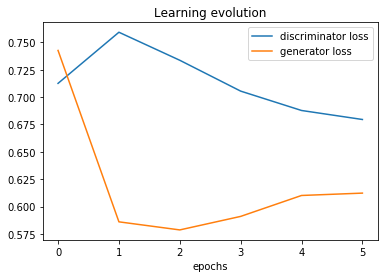

In [6]:
##################
# SAVING RESULTS #
##################
swagan = swagans[0]
swagan.plot_learning(save_mode=False, title=title)
if False:
    swagan.save_model(model_name=title)

In [18]:
x_eval = np.concatenate((x_test, x_test_bad))

result_swagan = evaluate(y_true=np.array([0. for _ in x_test] + [1. for _ in x_test_bad]),
                         y_pred=swagan.predict(x=x_eval))
print("\n"*4 + "="*15 + "\n" + "SWAGAN result")
print(result_swagan)
#################
# Classical MLP #
#################
mlp = Mlp(data_dim=data_dim, verbose=False)
d_loss_classical = mlp.train(x_train=np.concatenate((x_train, x_train_bad)),# x_balanced_train
                             y_train=np.array([0. for _ in x_train] + [1. for _ in x_train_bad]),# y_balanced_train
                             epochs=epochs*(switches+1))
result_mlp = evaluate(y_true=np.array([0. for _ in x_test] + [1. for _ in x_test_bad]),
                      y_pred=mlp.predict(x=x_eval))

print("\n"*2 + "="*15 + "\n" + "MLP result")
print(result_mlp)

# PCA

In [17]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)  

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
generated = swagan.generate(number=1000, x_bad=x_test_bad)

In [20]:
x_pca = pca.transform(x_train)
x_pca_gen = pca.transform(generated)
x_pca_ae = pca.transform(x_train_bad)

In [21]:
from matplotlib import pyplot as plt

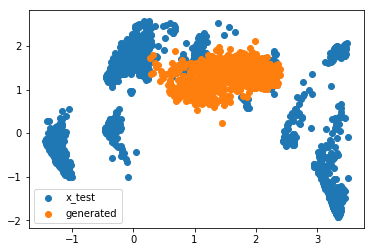

In [23]:
plt.scatter(x_pca[:,0].tolist(),x_pca[:,1].tolist(), label="x_test")
plt.scatter(x_pca_gen[:,0].tolist(),x_pca_gen[:,1].tolist(), label="generated")
# plt.scatter(x_pca_ae[:,0].tolist(),x_pca_ae[:,1].tolist(), label="auto_encoded")
plt.legend()
plt.savefig("PCA_swagan_trafic_input.png")
plt.show()
plt.close()

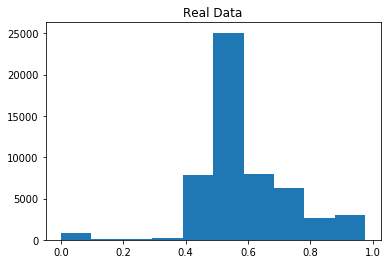

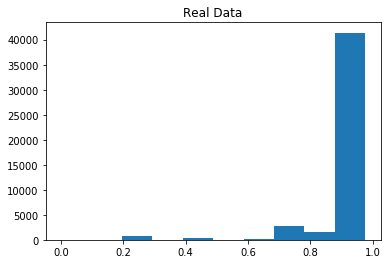

In [63]:
############
# Plotting #
############
benin_data = novgan_trafic_input.hurting(x=x_train, print_mode=True,title="Real Data")
malicious_data = novgan_trafic_input.hurting(x=x_train_bad, print_mode=True,title="Real Data")


/home/peseux/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


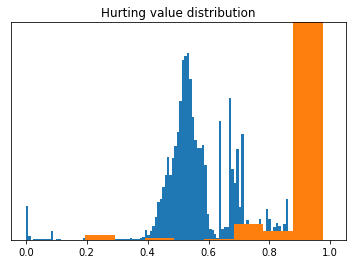

In [64]:
plt.hist(benin_data, normed=True, bins=120, label="benin")
plt.hist(malicious_data, normed=True, bins=10, label="malicious")
plt.xlim(-0.05,1.05)
plt.yticks([])
plt.ylim(0, 8)
plt.title("Hurting value distribution")
plt.savefig("hurting-distrib.png")
plt.show()
plt.close()

In [65]:
def eigth_threshold(x):
    if x>.8:
        return 1.0
    else:
        return 0.

In [66]:
benin_data = novgan_trafic_input.hurting(x=x_test, print_mode=False,title="Real Data")
malicious_data = novgan_trafic_input.hurting(x=x_test_bad, print_mode=False,title="Real Data")

In [70]:
y_pred= [eigth_threshold(b) for b in benin_data] + [eigth_threshold(m) for m in malicious_data] 

In [71]:
y_true = [.0 for _ in benin_data] + [1.0 for _ in malicious_data]

In [72]:
from sklearn.metrics import confusion_matrix as confusion_matrix, precision_score,f1_score, recall_score, accuracy_score


In [75]:
recall_score(y_pred=y_pred, y_true=y_true)

0.912468019785093

In [76]:
precision_score(y_pred=y_pred, y_true=y_true)

0.8942116435723001

In [77]:
f1_score(y_pred=y_pred, y_true=y_true)

0.9032475919531983

In [78]:
accuracy_score(y_pred=y_pred, y_true=y_true)

0.9090201868654394